In [3]:
# References: 
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
# https://github.com/adeveloperdiary/blog/blob/master/Computer_Vision/Canny_Edge_Detection/canny.py

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [4]:
def read_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.convert_image_dtype(img, tf.float32, saturate=False)
    return img
    
image = read_img("./data/dogs-vs-cats/train/cat.10000.jpg")
print(image.shape)

(359, 431, 1)


In [5]:
def gaussian_blur(img, kernel_size, sigma):
    def gaussian_filter(channels = 1):
        kernel_1D = tf.range(-kernel_size // 2 + 1.0, (kernel_size // 2) + 1.0)
        xx, yy = tf.meshgrid(kernel_1D, kernel_1D)
        
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel
    
    gaussian_kernel = gaussian_filter(1)
    return gaussian_kernel[..., tf.newaxis]

In [6]:
gaussian_kernel = gaussian_blur(image, 3, 27)
gaussian_image = tf.nn.conv2d(image[tf.newaxis, ...], gaussian_kernel, strides=1, padding='SAME')

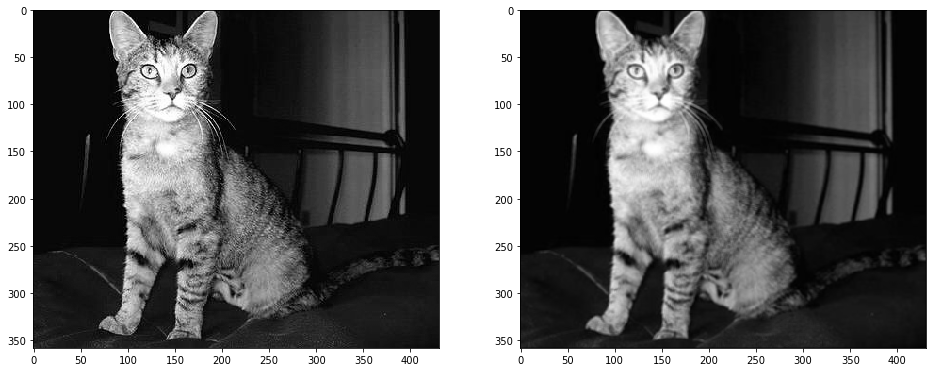

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(tf.squeeze(image), cmap=plt.cm.gray)
ax[1].imshow(tf.squeeze(gaussian_image), cmap=plt.cm.gray)
plt.show()

In [8]:
def sobel_edge_detection(image, kernel):
    kernel_x = kernel[..., tf.newaxis, tf.newaxis] # Assumption is image will be always in grayscale
    kernel_y = tf.transpose(kernel)[..., tf.newaxis, tf.newaxis]
    
    grad_x = tf.nn.conv2d(input=image, filters=kernel_x, strides=1, padding='SAME')
    grad_y = tf.nn.conv2d(input=image, filters=kernel_y, strides=1, padding='SAME')
    
    gradient_magnitude = tf.sqrt(tf.square(grad_x) + tf.square(grad_y))
    gradient_magnitude *= 255.0 / tf.reduce_max(gradient_magnitude)
    
    gradient_direction = tf.math.atan2(grad_y, grad_x)
    gradient_direction = tf.divide(gradient_direction, 0.017453292519943295)
    gradient_direction = tf.add(gradient_direction, 180) # as gradient direction can go negative
    
    return grad_x, grad_y, gradient_magnitude, gradient_direction

In [9]:
sobel_kernel = tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], tf.float32)

grad_x, grad_y, grad_magnitude, grad_direction = sobel_edge_detection(gaussian_image, sobel_kernel)

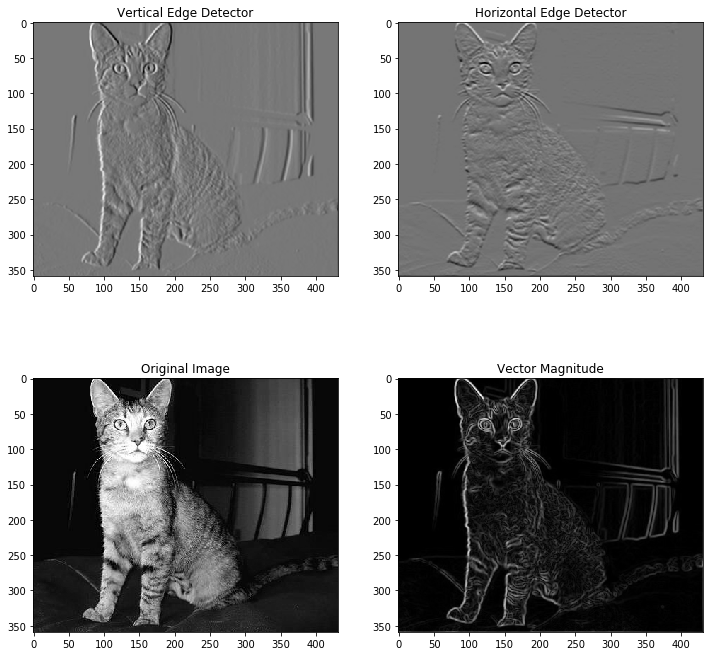

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(tf.squeeze(grad_x), cmap=plt.cm.gray)
ax[0, 0].set_title("Vertical Edge Detector")
ax[0, 1].imshow(tf.squeeze(grad_y), cmap=plt.cm.gray)
ax[0, 1].set_title("Horizontal Edge Detector")
ax[1, 0].imshow(tf.squeeze(image), cmap=plt.cm.gray)
ax[1, 0].set_title("Original Image")
ax[1, 1].imshow(tf.squeeze(grad_magnitude), cmap=plt.cm.gray)
ax[1, 1].set_title("Vector Magnitude")
plt.show()

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = rescale_frame(frame, percent=75)
    
    # Our operations on the frame come here
    image_np = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image_np = np.expand_dims(image_np, axis=0)
    
    grad_x, grad_y, grad_magnitude, grad_direction = sobel_edge_detection(image_np[..., tf.newaxis], sobel_kernel)
    
    # Display the resulting frame
    cv2.imshow('object detection', tf.squeeze(grad_magnitude).numpy())
    
    # Wait for Esc key to stop 
    k = cv2.waitKey(5) & 0xFF
    if k == 27: 
        break
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [109]:
def non_max_suppression(gradient_magnitude, gradient_direction, verbose = True):
    magnitude = tf.squeeze(gradient_magnitude)
    direction = tf.squeeze(gradient_direction)
    
    img_row, img_col = magnitude.shape
    output = np.zeros(magnitude.shape)

    for i in range(1,img_row-1):
        for j in range(1,img_col-1):
            angle = direction[i, j]
            
            #angle 0
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                before = magnitude[i, j-1]
                after = magnitude[i, j+1]
            #angle 45
            elif (22.5 <= angle < 67.5):
                before = magnitude[i+1, j-1]
                after = magnitude[i-1, j+1]
            #angle 90
            elif (67.5 <= angle < 112.5):
                after = magnitude[i+1, j]
                before = magnitude[i-1, j]
            #angle 135
            else:
                after = magnitude[i-1, j-1]
                before = magnitude[i+1, j+1]

            if (magnitude[i,j] >= after) and (magnitude[i,j] >= before):
                output[i,j] = magnitude[i,j]

    return output

In [110]:
suppression = non_max_suppression(grad_magnitude, grad_direction)

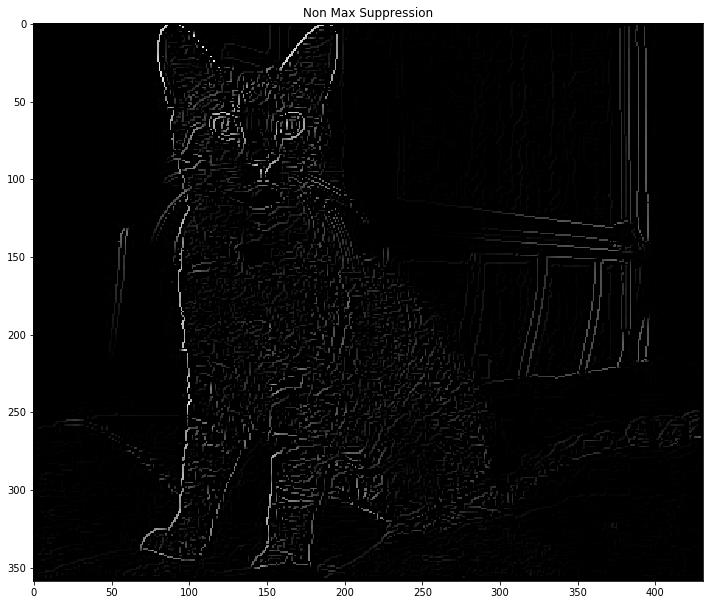

In [111]:
fig = plt.subplots(figsize=(12, 12))
plt.imshow(suppression, cmap='gray')
plt.title("Non Max Suppression")
plt.show()